In [1]:
import numpy as np
import pandas as pd
import os
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.stats import norm

In [2]:
## Getting a list of all event files in the right format for the read data function ##

files = os.listdir('/Users/chanelbrown/Desktop/Notebooks/All CSV Files - without fuel adjusted lap times')

all_events = []

for file in files:
    all_events.append(file[0:16])
    
all_events.remove('.DS_Store') 

In [3]:
## Remove 2020 events ##

drop = []

for event in all_events:
    if event[-4:] == '2020':
        drop.append(event)
        
events = [x for x in all_events if x not in drop]    

In [4]:
## Function reads data into a Pandas DataFrame from a CSV file ##

def read_data(filename):
    
    df = pd.read_csv('/Users/chanelbrown/Desktop/Notebooks/All CSV Files - without fuel adjusted lap times/%s.csv' % (filename))
    
    # select required features
    d = df[['Season', 'Circuit', 'Session', 'Driver Short Name', 'Team', 'Sector 1', 'Sector 2', 'Sector 3', 
            'Full Lap', 'Full Lap (no fuel adjustment)']].copy()
    
    ''' some sectors have missing values (probably where car has been taken off, 
    convert the white space to NaN objects and drop them'''
    
    d.replace(' ', np.nan, inplace = True) 
                                              
    data = d.dropna()
    
    return data

In [5]:
## Function finds which drivers made it into each sub-session ##

def find_drivers(data, session):
    
    session_data = data[data.loc[:,'Session'] == session]
    drivers = list(np.unique(session_data['Driver Short Name']))
    
    return drivers

In [6]:
## Function finds the fastest actual lap for each driver and also fastest theoretical based on sector times## 

def fastest_actual_lap(data, driver, session):
    
    driver_sesh = data.loc[(data.loc[:, 'Driver Short Name'] == driver) & (data.Session == session), :]
    
    fastest_actual = np.min(driver_sesh['Full Lap (no fuel adjustment)']) # not fuel adjusted
    
    S1 = float(np.min(driver_sesh['Sector 1'])) # fuel adjusted sector times
    S2 = float(np.min(driver_sesh['Sector 2']))
    S3 = float(np.min(driver_sesh['Sector 3']))
    
    fastest_theoretical = round(S1 + S2 + S3, 3)
    
    season = data.loc[1, 'Season'] # finds the season of the fastest actual lap
    circuit = data.loc[1, 'Circuit'] # circuit
    
    team = driver_sesh.loc[driver_sesh.loc[:, 'Full Lap (no fuel adjustment)'] == fastest_actual].iloc[0, 4] # finds the team of the fastest actual lap
    
    return season, circuit, team, driver, session, fastest_actual, fastest_theoretical, S1, S2, S3

In [7]:
## Function puts the fastest actual lap per team into a dictionary where the qualifying session is the key ##

def create_qualifier_dict(data, sessions):
    
    qualifiers = {} # {'Q1' : df, 'Q2': df, 'Q3': df}
    
    for s in sessions:

        drivers = find_drivers(data, s)

        df = pd.DataFrame(columns = ['Season', 'Circuit', 'Team', 'Driver', 'Session', 'Fastest Actual Lap Time', 'Fastest Theoretical Lap Time'])

        for d in drivers:

            season, circuit, team, driver, session, fastest_actual, fastest_theoretical, S1, S2, S3 = fastest_actual_lap(data, driver = d, session = s) 
            
            to_append = [season, circuit, team, driver, session, fastest_actual, fastest_theoretical] # values to append to empty dataframe
            a_series = pd.Series(to_append, index = df.columns) # convert into a series first
            df = df.append(a_series, ignore_index = True) 

        df = df.sort_values(by = ['Fastest Actual Lap Time'])

        qualifiers[s] = df # adds each set of results into a dictionary that has {qualifying round: data frame of fastest laps}
       
        
    return qualifiers, circuit

In [8]:
## Runs through all events available and works out actual laps for each qualifying session specified ##

sessions = ['Q1', 'Q2']

q = []
c = []

for event in events:
    
    data = read_data(event)
   
    qualifiers, circuit = create_qualifier_dict(data, sessions)
    
    q.append(qualifiers)
    c.append(circuit)

assert len(q) == len(c)

circuit_fastest_laps = defaultdict(list) # returns a dictionary where the keys are circuits and the values are qualifying dictionaries for each year

for i, j in zip(c, q):
    circuit_fastest_laps[i].append(j)

print(circuit_fastest_laps.keys())

dict_keys(['Sochi', 'Monza', 'Suzuka', 'A1-Ring', 'Melbourne', 'Sepang', 'Hockenheim', 'Mexico City', 'Bahrain', 'Montreal', 'Spa', 'Baku', 'Monaco', 'Austin', 'Interlagos', 'Silverstone', 'Shanghai', 'Abu Dhabi', 'Barcelona', 'Singapore', 'Budapest', 'Paul Ricard'])


In [9]:
circuit_fastest_laps['Sochi'][0]['Q2']

,Season,Circuit,Team,Driver,Session,Fastest Actual Lap Time,Fastest Theoretical Lap Time
1,2017,Sochi,Mercedes AMG,BOT,Q2,93.264,93.125
9,2017,Sochi,Ferrari,RAI,Q2,93.663,93.524
2,2017,Sochi,Mercedes AMG,HAM,Q2,93.760,93.621
14,2017,Sochi,Ferrari,VET,Q2,94.038,93.519
6,2017,Sochi,Williams,MAS,Q2,95.049,94.895
13,2017,Sochi,Red Bull,VER,Q2,95.221,94.785
3,2017,Sochi,Renault,HUL,Q2,95.328,95.153
10,2017,Sochi,Red Bull,RIC,Q2,95.483,94.925
8,2017,Sochi,Force India,PER,Q2,95.513,95.374
7,2017,Sochi,Force India,OCO,Q2,95.729,95.413


In [10]:
def find_cutoff(data_dict, track, season):
    
    Q1_data = data_dict[track][season]['Q1']
    Q2_data = data_dict[track][season]['Q2']

    Q1_cut = Q1_data.iloc[:, -2].nsmallest(16).iloc[-1] # 16th place is the score to beat
    Q2_cut = Q2_data.iloc[:, -2].nsmallest(11).iloc[-1] # 11th place is the score to beat

    Q1_cut_theoretical = Q1_data.iloc[:, -1].nsmallest(16).iloc[-1] # 16th place is the score to beat
    Q2_cut_theoretical = Q2_data.iloc[:, -1].nsmallest(11).iloc[-1] # 11th place is the score to beat

    year = Q1_data.iloc[0, 0]  
    
    return Q1_cut, Q2_cut, Q1_cut_theoretical, Q2_cut_theoretical, year

In [11]:
find_cutoff(circuit_fastest_laps, 'Paul Ricard', 1)

(91.564, 90.461, 91.417, 90.16, 2019)

In [12]:
## Create dictionaries for each track that contain cutoff per year for actual and theoretical {Track: [[17_actual_cut, ..], [17_theoretical_cut, ..]]}##

Q1 = {}
Q2 = {}

for track in circuit_fastest_laps.keys():

    ac_Q1 = [0, 0, 0]
    t_Q1 = [0, 0, 0]

    ac_Q2 = [0, 0, 0]
    t_Q2 = [0, 0, 0]

    for i in range(0, 3):

        try:
            Q1_cut, Q2_cut, Q1_cut_theoretical, Q2_cut_theoretical, year = find_cutoff(circuit_fastest_laps, track, i)


            if year == 2017:
                ac_Q1[0] = Q1_cut
                ac_Q2[0] = Q2_cut
                t_Q1[0] = Q1_cut_theoretical
                t_Q2[0] = Q2_cut_theoretical
            else:
                pass

            if year == 2018:
                ac_Q1[1] = Q1_cut
                ac_Q2[1] = Q2_cut
                t_Q1[1] = Q1_cut_theoretical
                t_Q2[1] = Q2_cut_theoretical
            else:
                pass

            if year == 2019:
                ac_Q1[2] = Q1_cut
                ac_Q2[2] = Q2_cut
                t_Q1[2] = Q1_cut_theoretical
                t_Q2[2] = Q2_cut_theoretical

            else:
                pass 

            Q1[track] = [ac_Q1, t_Q1]
            Q2[track] = [ac_Q2, t_Q2]

        except:
            pass

In [13]:
Q1

{'Sochi': [[96.462, 95.037, 94.84], [96.214, 94.757, 94.612]],
 'Monza': [[100.489, 81.888, 80.784], [100.102, 81.737, 80.658]],
 'Suzuka': [[90.849, 90.361, 89.822], [90.712, 90.183, 89.664]],
 'A1-Ring': [[66.345, 65.271, 64.789], [66.14, 65.157, 64.644]],
 'Melbourne': [[86.419, 84.532, 83.017], [86.2, 84.361, 82.803]],
 'Sepang': [[93.308, 0, 0], [93.197, 0, 0]],
 'Hockenheim': [[0, 73.72, 73.333], [0, 73.525, 73.175]],
 'Mexico City': [[79.176, 76.911, 78.065], [79.122, 76.849, 77.655]],
 'Bahrain': [[92.118, 90.53, 90.026], [91.931, 90.419, 89.873]],
 'Montreal': [[74.182, 73.047, 72.197], [73.892, 72.962, 72.029]],
 'Spa': [[106.028, 104.489, 106.435], [105.874, 104.114, 106.264]],
 'Baku': [[104.334, 104.489, 102.63], [104.198, 104.283, 102.488]],
 'Monaco': [[74.101, 73.179, 72.149], [74.019, 73.013, 72.041]],
 'Austin': [[96.842, 95.294, 94.226], [96.72, 95.16, 94.09]],
 'Interlagos': [[70.678, 69.269, 69.32], [70.496, 69.152, 69.127]],
 'Silverstone': [[102.573, 88.456, 86.6

In [14]:
Q2

{'Sochi': [[95.948, 93.995, 93.95], [95.555, 93.855, 93.763]],
 'Monza': [[97.582, 81.669, 80.517], [97.635, 81.572, 80.391]],
 'Suzuka': [[89.778, 89.864, 89.254], [89.641, 89.73, 89.043]],
 'A1-Ring': [[65.597, 64.845, 64.49], [65.461, 64.627, 64.322]],
 'Melbourne': [[85.081, 83.692, 82.562], [84.812, 83.426, 82.382]],
 'Sepang': [[92.034, 0, 0], [92.291, 0, 0]],
 'Hockenheim': [[0, 73.657, 72.786], [0, 73.553, 72.589]],
 'Mexico City': [[78.099, 76.844, 76.687], [78.045, 76.777, 76.619]],
 'Bahrain': [[90.923, 90.105, 89.488], [90.776, 89.994, 89.347]],
 'Montreal': [[73.69, 72.606, 71.8], [73.445, 72.402, 71.715]],
 'Spa': [[105.09, 103.844, 104.797], [104.936, 103.696, 104.626]],
 'Baku': [[103.186, 103.585, 102.398], [102.74, 103.406, 102.125]],
 'Monaco': [[73.516, 72.411, 71.67], [73.499, 72.165, 71.616]],
 'Austin': [[95.155, 94.566, 93.785], [94.981, 94.39, 93.63]],
 'Interlagos': [[69.83, 68.659, 68.868], [69.683, 68.474, 68.788]],
 'Silverstone': [[90.193, 87.901, 86.519],

In [15]:
## Data that has to be taken out due to rain and red flags 1 means the data is good to keep for the year index position, 0 means its bad ##

Q1_bad_data = {'Sochi': [1, 1, 0], 'Monza': [0, 1, 0], 'Suzuka': [0, 0, 0], 'A1-Ring': [1, 1, 1],
              'Melbourne': [1, 1, 1], 'Hockenheim': [0, 1, 1], 'Mexico City': [1, 1, 1], 'Bahrain': [1, 0, 1], 
               'Montreal': [1, 1, 1], 'Spa': [1, 1, 0], 'Baku': [1, 1, 0], 'Monaco': [1, 1, 1],
               'Silverstone': [0, 0, 1], 'Shanghai': [1, 1, 1], 'Abu Dhabi': [1, 1, 1], 'Barcelona': [1, 1, 1],
               'Singapore': [1, 1, 1], 'Paul Ricard': [0, 1, 1], 'Interlagos': [0, 1, 1], 'Budapest': [1, 0, 1], 
               'Austin': [1, 1, 1], 'Portimao': [0, 0, 0], 'Nurburgring': [0, 0, 0], 
               'Mugello': [0, 0, 0], 'Imola': [0, 0, 0], 'Istanbul': [0, 0, 0], 'Sakhir': [0, 0, 0]}

Q2_bad_data = {'Sochi': [1, 1, 1], 'Monza': [0, 1, 1], 'Suzuka': [1, 1, 1], 'A1-Ring': [1, 1, 1],
              'Melbourne': [1, 1, 1], 'Hockenheim': [0, 0, 1], 'Mexico City': [1, 1, 1], 'Bahrain': [1, 1, 1], 
               'Montreal': [1, 1, 1], 'Spa': [1, 1, 1], 'Baku': [1, 1, 0], 'Monaco': [1, 1, 1],
               'Silverstone': [0, 1, 1], 'Shanghai': [1, 1, 1], 'Abu Dhabi': [1, 1, 1], 'Barcelona': [1, 1, 1],
               'Singapore': [1, 1, 1], 'Paul Ricard': [0, 1, 1], 'Interlagos': [0, 1, 1], 'Budapest': [1, 0, 1], 
               'Austin': [1, 1, 1], 'Portimao': [0, 0, 0], 'Nurburgring': [0, 0, 0], 
               'Mugello': [0, 0, 0], 'Imola': [0, 0, 0], 'Istanbul': [0, 0, 0], 'Sakhir': [0, 0, 0]}

In [16]:
## Remove rain and red flag events ##

def remove_bad_data(bad_data, cutoff):
    
    clean_data = {}

    for track in bad_data.keys():
        data = bad_data[track]

        if data[0] == 1:
            data_17_ac = cutoff[track][0][0]
            data_17_t = cutoff[track][1][0]
        else:
            data_17_ac = 0
            data_17_t = 0

        if data[1] == 1:
            data_18_ac = cutoff[track][0][1]
            data_18_t = cutoff[track][1][1]
        else:
            data_18_ac = 0
            data_18_t = 0

        if data[2] == 1:
            data_19_ac = cutoff[track][0][2]
            data_19_t = cutoff[track][1][2]
        else:
            data_19_ac = 0
            data_19_t = 0
    
        clean_data[track] = [[data_17_ac, data_18_ac, data_19_ac], [data_17_t, data_18_t, data_19_t]]

    return clean_data

In [17]:
Q1_data = remove_bad_data(Q1_bad_data, Q1)
Q2_data = remove_bad_data(Q2_bad_data, Q2)

In [18]:
Q1_data

{'Sochi': [[96.462, 95.037, 0], [96.214, 94.757, 0]],
 'Monza': [[0, 81.888, 0], [0, 81.737, 0]],
 'Suzuka': [[0, 0, 0], [0, 0, 0]],
 'A1-Ring': [[66.345, 65.271, 64.789], [66.14, 65.157, 64.644]],
 'Melbourne': [[86.419, 84.532, 83.017], [86.2, 84.361, 82.803]],
 'Hockenheim': [[0, 73.72, 73.333], [0, 73.525, 73.175]],
 'Mexico City': [[79.176, 76.911, 78.065], [79.122, 76.849, 77.655]],
 'Bahrain': [[92.118, 0, 90.026], [91.931, 0, 89.873]],
 'Montreal': [[74.182, 73.047, 72.197], [73.892, 72.962, 72.029]],
 'Spa': [[106.028, 104.489, 0], [105.874, 104.114, 0]],
 'Baku': [[104.334, 104.489, 0], [104.198, 104.283, 0]],
 'Monaco': [[74.101, 73.179, 72.149], [74.019, 73.013, 72.041]],
 'Silverstone': [[0, 0, 86.662], [0, 0, 86.485]],
 'Shanghai': [[95.023, 94.062, 94.292], [94.84, 93.86, 94.026]],
 'Abu Dhabi': [[99.516, 97.994, 98.051], [99.332, 97.804, 97.763]],
 'Barcelona': [[82.332, 78.923, 78.404], [82.118, 78.819, 78.123]],
 'Singapore': [[104.014, 99.644, 99.957], [103.907, 99.4

In [19]:
indexes = []
cols =  ['Actual 2017', 'Actual 2018', 'Actual 2019', 'Theoretical 2017', 
         'Theoretical 2018', 'Theoretical 2019']
vals = []

for key, value in Q1_data.items():
    
    indexes.append(key)
    
    a_t = value[0] + value[1]
    vals.append(a_t)

Q1_df = pd.DataFrame(vals, columns = cols, index = indexes)
Q1_df = Q1_df.replace(0, np.NaN)
Q1_df['Actual Mean'] = round(Q1_df[['Actual 2017', 'Actual 2018', 'Actual 2019']].mean(axis = 1), 3)
Q1_df['Actual Sd'] = round(Q1_df[['Actual 2017', 'Actual 2018', 'Actual 2019']].std(axis = 1), 3)

Q1_df['Theoretical SF_17'] = np.round(norm.sf(x = Q1_df['Theoretical 2017'], loc = Q1_df['Actual Mean'], scale = Q1_df['Actual Sd']), 3) # sf = survival function returns 1 - cdf
Q1_df['Theoretical SF_18'] = np.round(norm.sf(x = Q1_df['Theoretical 2018'], loc = Q1_df['Actual Mean'], scale = Q1_df['Actual Sd']), 3) # sf = survival function returns 1 - cdf
Q1_df['Theoretical SF_19'] = np.round(norm.sf(x = Q1_df['Theoretical 2019'], loc = Q1_df['Actual Mean'], scale = Q1_df['Actual Sd']), 3) # sf = survival function returns 1 - cdf

In [20]:
Q1_df

,Actual 2017,Actual 2018,Actual 2019,Theoretical 2017,Theoretical 2018,Theoretical 2019,Actual Mean,Actual Sd,Theoretical SF_17,Theoretical SF_18,Theoretical SF_19
Sochi,96.462,95.037,NaN,96.214,94.757,NaN,95.750,1.008,0.323,0.838,NaN
Monza,NaN,81.888,NaN,NaN,81.737,NaN,81.888,NaN,NaN,NaN,NaN
Suzuka,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1-Ring,66.345,65.271,64.789,66.140,65.157,64.644,65.468,0.797,0.200,0.652,0.849
Melbourne,86.419,84.532,83.017,86.200,84.361,82.803,84.656,1.704,0.182,0.569,0.862
Hockenheim,NaN,73.720,73.333,NaN,73.525,73.175,73.526,0.274,NaN,0.501,0.900
Mexico City,79.176,76.911,78.065,79.122,76.849,77.655,78.051,1.133,0.172,0.856,0.637
Bahrain,92.118,NaN,90.026,91.931,NaN,89.873,91.072,1.479,0.281,NaN,0.791
Montreal,74.182,73.047,72.197,73.892,72.962,72.029,73.142,0.996,0.226,0.572,0.868
Spa,106.028,104.489,NaN,105.874,104.114,NaN,105.258,1.088,0.286,0.853,NaN


In [21]:
Q2_data

{'Sochi': [[95.948, 93.995, 93.95], [95.555, 93.855, 93.763]],
 'Monza': [[0, 81.669, 80.517], [0, 81.572, 80.391]],
 'Suzuka': [[89.778, 89.864, 89.254], [89.641, 89.73, 89.043]],
 'A1-Ring': [[65.597, 64.845, 64.49], [65.461, 64.627, 64.322]],
 'Melbourne': [[85.081, 83.692, 82.562], [84.812, 83.426, 82.382]],
 'Hockenheim': [[0, 0, 72.786], [0, 0, 72.589]],
 'Mexico City': [[78.099, 76.844, 76.687], [78.045, 76.777, 76.619]],
 'Bahrain': [[90.923, 90.105, 89.488], [90.776, 89.994, 89.347]],
 'Montreal': [[73.69, 72.606, 71.8], [73.445, 72.402, 71.715]],
 'Spa': [[105.09, 103.844, 104.797], [104.936, 103.696, 104.626]],
 'Baku': [[103.186, 103.585, 0], [102.74, 103.406, 0]],
 'Monaco': [[73.516, 72.411, 71.67], [73.499, 72.165, 71.616]],
 'Silverstone': [[0, 87.901, 86.519], [0, 87.779, 86.387]],
 'Shanghai': [[94.15, 92.986, 93.236], [94.013, 92.85, 93.036]],
 'Abu Dhabi': [[98.636, 96.982, 97.055], [98.448, 96.775, 96.867]],
 'Barcelona': [[81.329, 78.323, 77.338], [81.154, 78.104,

In [25]:
indexes = []
cols =  ['Actual 2017', 'Actual 2018', 'Actual 2019', 'Theoretical 2017', 
         'Theoretical 2018', 'Theoretical 2019']
vals = []

for key, value in Q2_data.items():
    
    indexes.append(key)
    
    a_t = value[0] + value[1]
    vals.append(a_t)

Q2_df = pd.DataFrame(vals, columns = cols, index = indexes)
Q2_df = Q2_df.replace(0, np.NaN)
Q2_df['Actual Mean'] = round(Q2_df[['Actual 2017', 'Actual 2018', 'Actual 2019']].mean(axis = 1), 3)
Q2_df['Actual Sd'] = round(Q2_df[['Actual 2017', 'Actual 2018', 'Actual 2019']].std(axis = 1), 3)

Q2_df['Theoretical SF_17'] = np.round(norm.sf(x = Q2_df['Theoretical 2017'], loc = Q2_df['Actual Mean'], scale = Q2_df['Actual Sd']), 3) # sf = survival function returns 1 - cdf
Q2_df['Theoretical SF_18'] = np.round(norm.sf(x = Q2_df['Theoretical 2018'], loc = Q2_df['Actual Mean'], scale = Q2_df['Actual Sd']), 3) # sf = survival function returns 1 - cdf
Q2_df['Theoretical SF_19'] = np.round(norm.sf(x = Q2_df['Theoretical 2019'], loc = Q2_df['Actual Mean'], scale = Q2_df['Actual Sd']), 3) # sf = survival function returns 1 - cdf

In [26]:
Q2_df

,Actual 2017,Actual 2018,Actual 2019,Theoretical 2017,Theoretical 2018,Theoretical 2019,Actual Mean,Actual Sd,Theoretical SF_17,Theoretical SF_18,Theoretical SF_19
Sochi,95.948,93.995,93.950,95.555,93.855,93.763,94.631,1.141,0.209,0.752,0.777
Monza,NaN,81.669,80.517,NaN,81.572,80.391,81.093,0.815,NaN,0.278,0.805
Suzuka,89.778,89.864,89.254,89.641,89.730,89.043,89.632,0.330,0.489,0.383,0.963
A1-Ring,65.597,64.845,64.490,65.461,64.627,64.322,64.977,0.565,0.196,0.732,0.877
Melbourne,85.081,83.692,82.562,84.812,83.426,82.382,83.778,1.262,0.206,0.610,0.866
Hockenheim,NaN,NaN,72.786,NaN,NaN,72.589,72.786,NaN,NaN,NaN,NaN
Mexico City,78.099,76.844,76.687,78.045,76.777,76.619,77.210,0.774,0.140,0.712,0.777
Bahrain,90.923,90.105,89.488,90.776,89.994,89.347,90.172,0.720,0.201,0.598,0.874
Montreal,73.690,72.606,71.800,73.445,72.402,71.715,72.699,0.948,0.216,0.623,0.850
Spa,105.090,103.844,104.797,104.936,103.696,104.626,104.577,0.651,0.291,0.912,0.470


In [110]:
Q1_df.to_csv('Fastest Theoretical Lap Time Q1.csv')
Q2_df.to_csv('Fastest Theoretical Lap Time Q2.csv')

In [107]:
# Plot the posterior predictive dist - this will enable a quick check for individual drivers ##

def norm_curves(track, quali, mean, sd, target_17, target_18, target_19, cdf_17, cdf_18, cdf_19):

    fig, ax = plt.subplots(figsize = (10, 10))
    
    if sd < 0.1:
        boundary = 0.025 * mean
    elif 0.1< sd < 0.5:
        boundary = 0.01 * mean
    elif 0.5 < sd < 1:
        boundary = 0.03 * mean
    else:
        boundary = 0.05 * mean

    x_axis = np.linspace(mean - boundary, mean + boundary, 1000)
    ax.plot(x_axis, norm.pdf(x_axis, loc = mean, scale = sd), color = 'b')
    ax.set_title(f'{track} {quali}, $N \sim ({mean:.3f}, ${sd:.3f}^2$)$', fontsize = '15')
    ax.set_xlabel('Lap time (s)', fontsize = '14')
    ax.set_ylabel('Probability Density', fontsize = '14')
    ax.tick_params(axis = 'both', labelsize = 12)
    
    x_19 = np.linspace(target_19, mean + boundary, 1000)
    x_18 = np.linspace(target_18, mean + boundary, 1000)
    x_17 = np.linspace(target_17, mean + boundary, 1000)
    
    if np.isnan(target_19):
        pass
    else:
        ax.fill_between(x_19, norm.pdf(x_19, loc = mean, scale = sd), alpha = 0.2, color = 'g')
        
    if np.isnan(target_18):
        pass 
    else:
        ax.fill_between(x_18, norm.pdf(x_18, loc = mean, scale = sd), alpha = 0.5, color = 'g')
    
    if np.isnan(target_17):
        pass
    else:
        ax.fill_between(x_17, norm.pdf(x_17, loc = mean, scale = sd), alpha = 0.8, color = 'g')
    
    legend_col = [Line2D([0], [0], linestyle = '', marker = 's', alpha = 0.2, color = 'g'), 
                  Line2D([0], [0], linestyle = '', marker = 's', alpha = 0.5, color = 'g'),
                  Line2D([0], [0], linestyle = '', marker = 's', alpha = 0.8, color = 'g'),
                 Line2D([0], [0], color = 'b')]
    
    legend_name = [f'Theoretical 2019: {cdf_19:.3f}', f'Theoretical 2018: {cdf_18:.3f}', f'Theoretical 2017: {cdf_17:.3f}', 'Actual Historical Distribution']
    
    ax.legend(legend_col, legend_name, fontsize = 10)
    
    ax.grid(True)
    
    save_path = '/Users/chanelbrown/Desktop/Final Code Submission/Models/Fastest Theoretical Lap Model/Plots'
    
    plt.savefig(f'{save_path}/Fastest Theoretical Lap Plot: {track}_{quali}.png')
    plt.show()

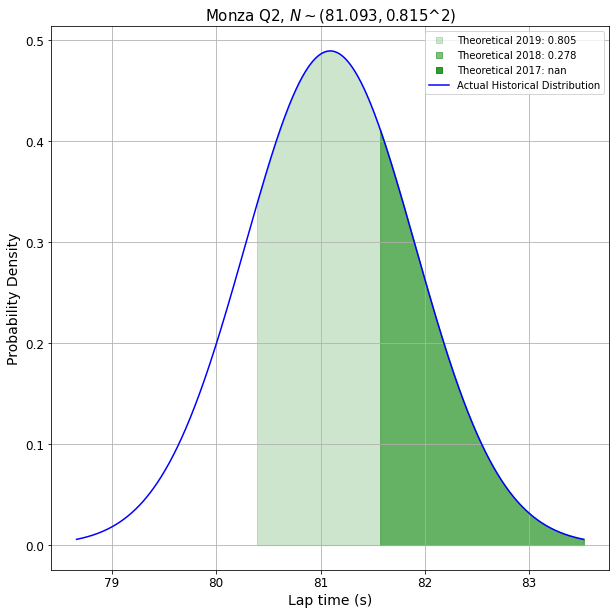

In [105]:
norm_curves('Monza', 'Q2', Q2_df.loc['Monza', 'Actual Mean'],  Q2_df.loc['Monza', 'Actual Sd'], Q2_df.loc['Monza', 'Theoretical 2017'], 
            Q2_df.loc['Monza', 'Theoretical 2018'], Q2_df.loc['Monza', 'Theoretical 2019'],
            Q2_df.loc['Monza', 'Theoretical SF_17'], Q2_df.loc['Monza', 'Theoretical SF_18'], Q2_df.loc['Monza', 'Theoretical SF_19'])

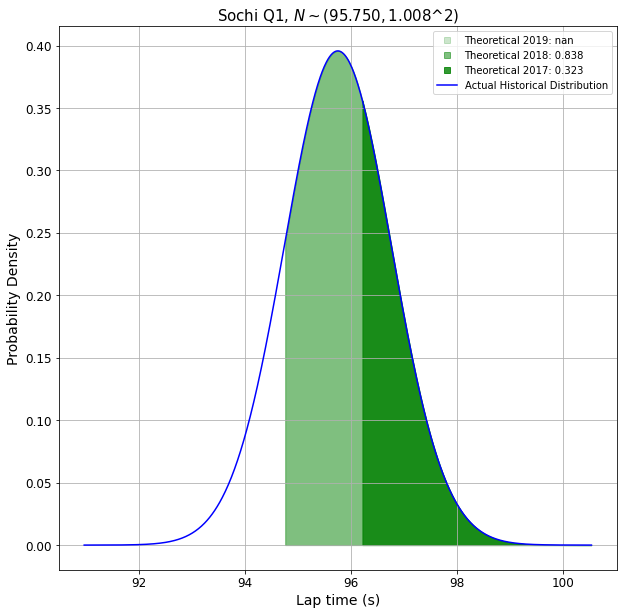

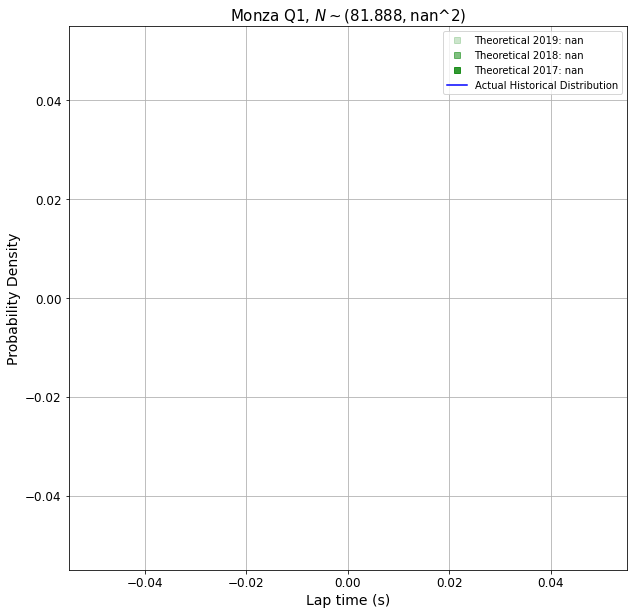

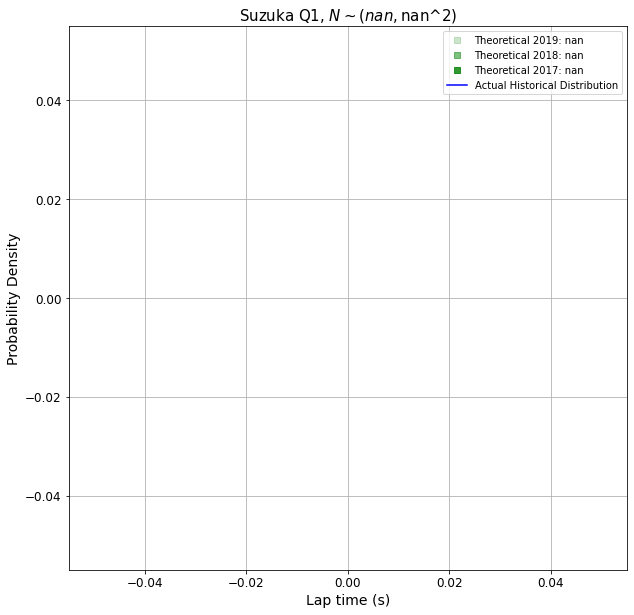

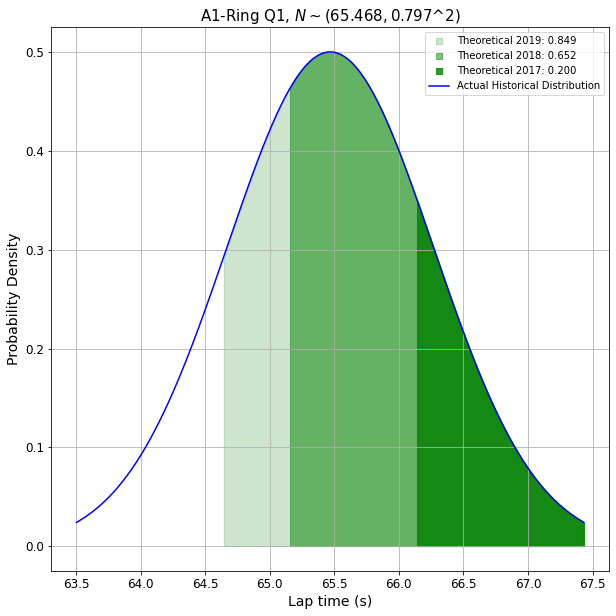

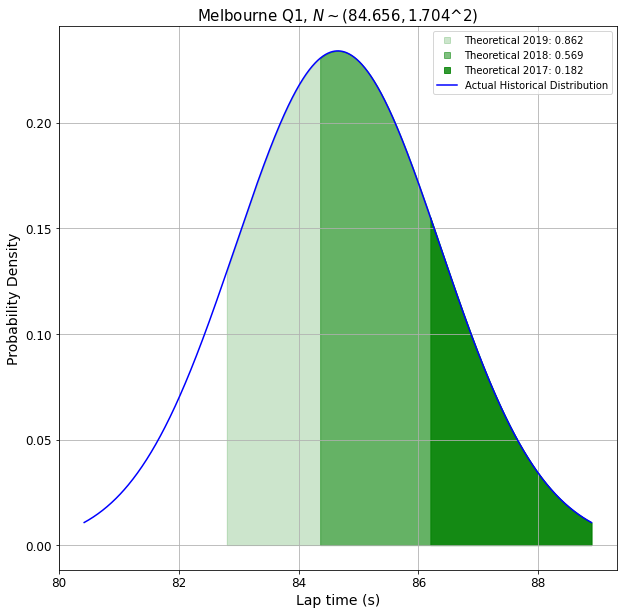

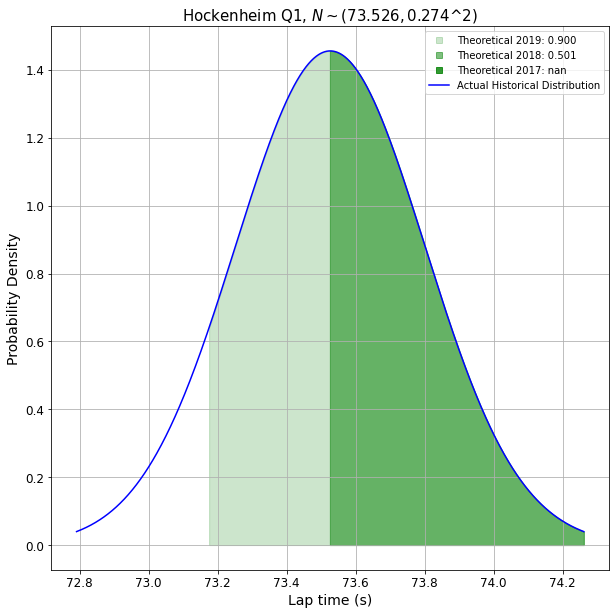

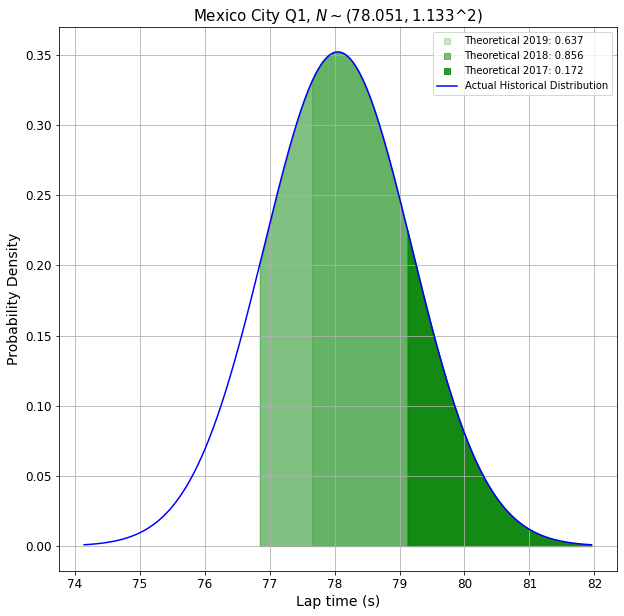

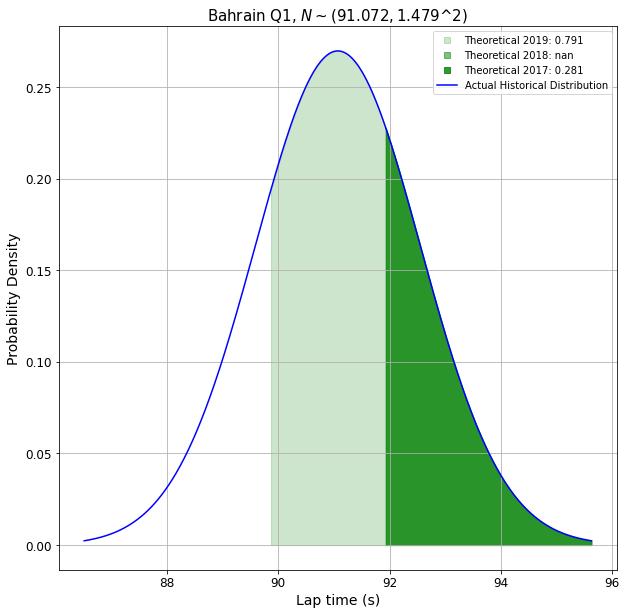

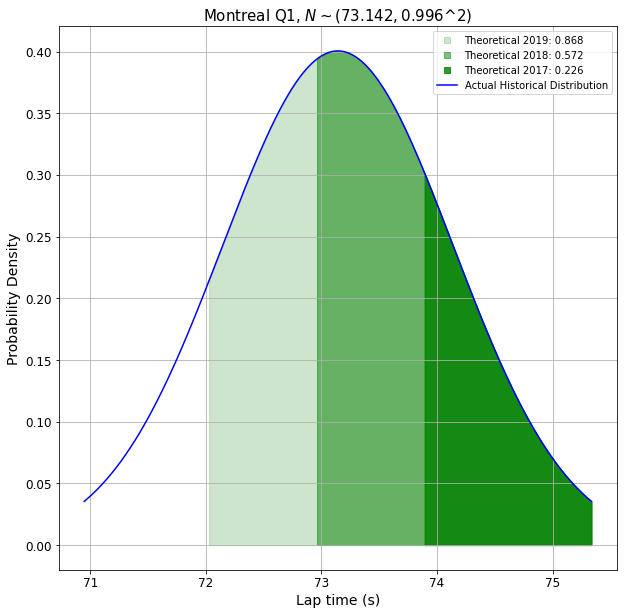

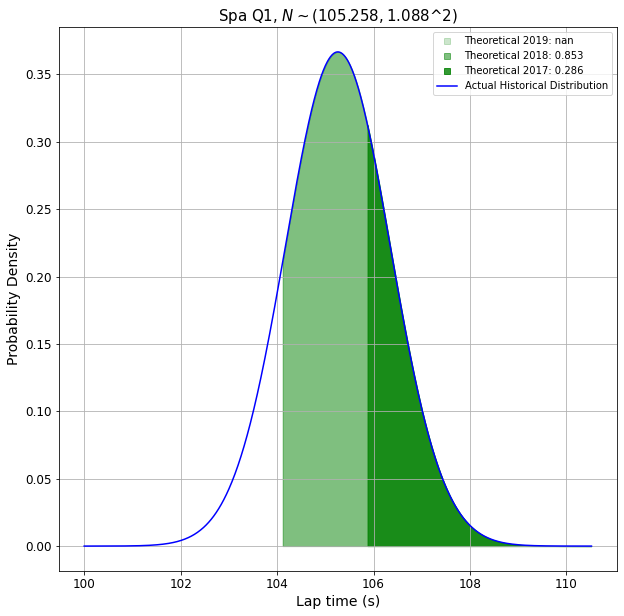

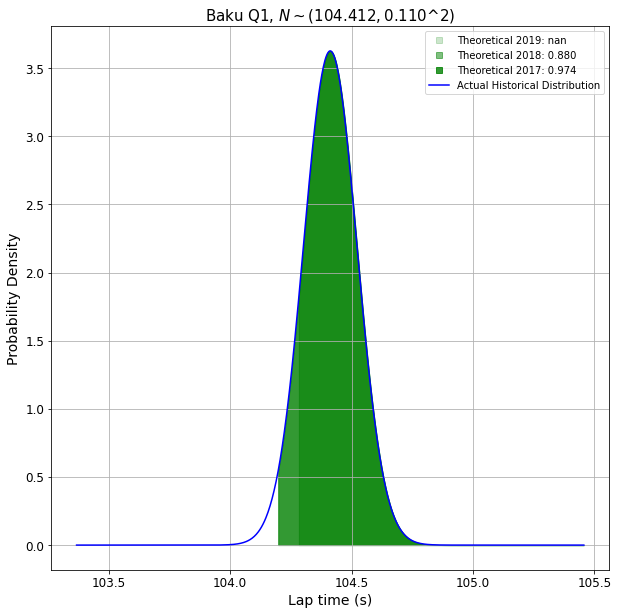

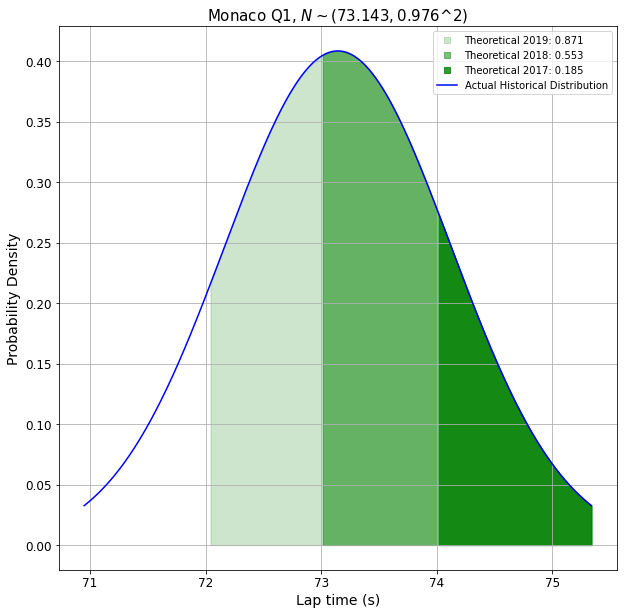

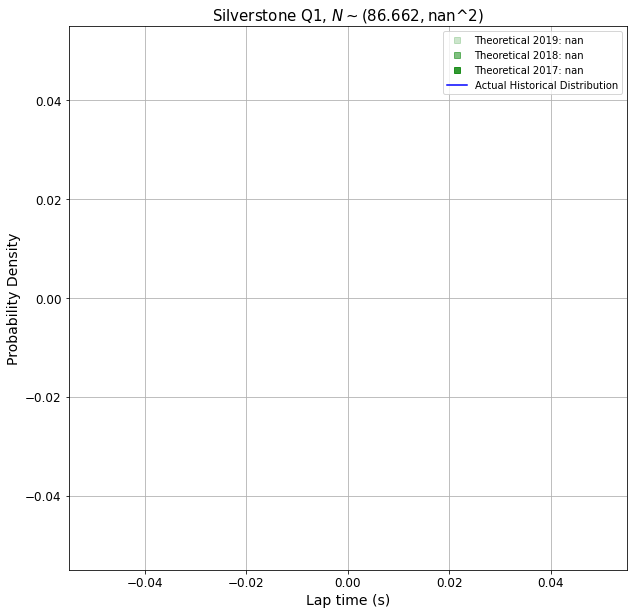

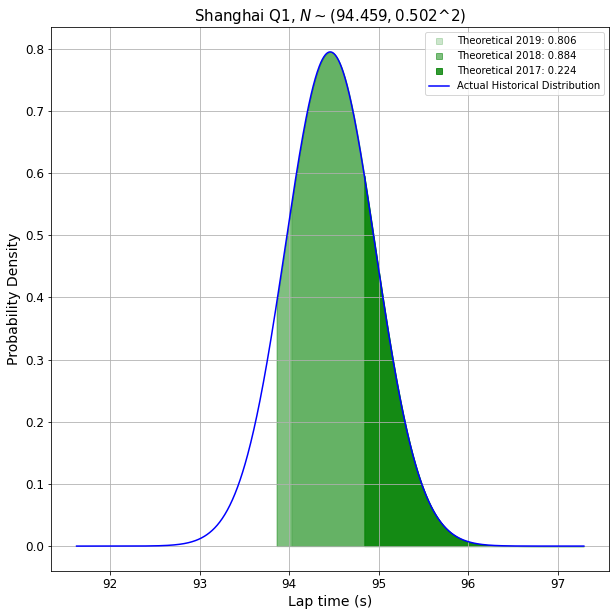

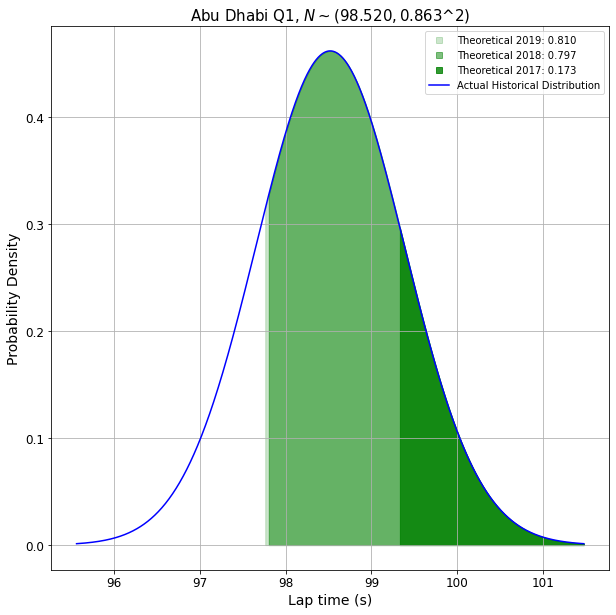

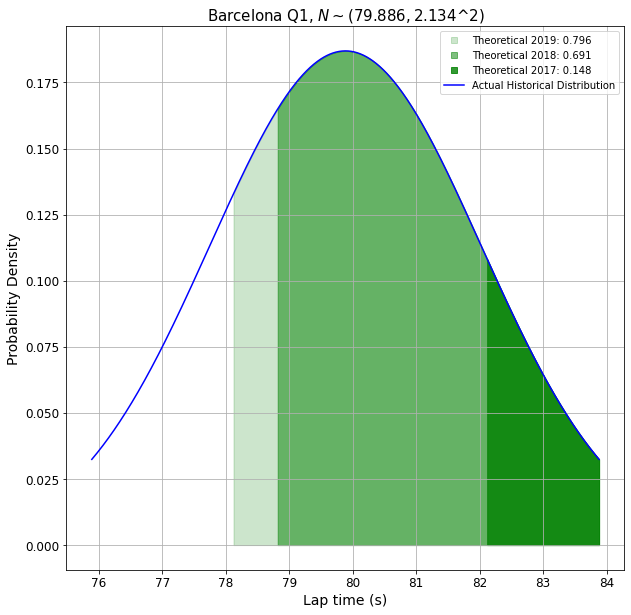

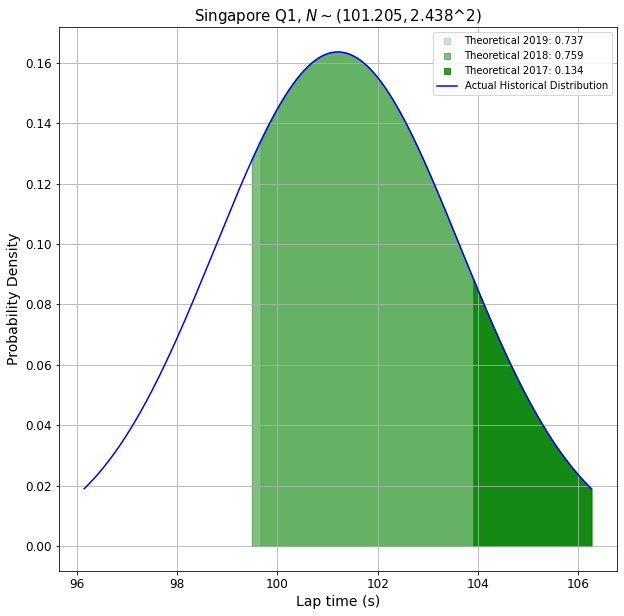

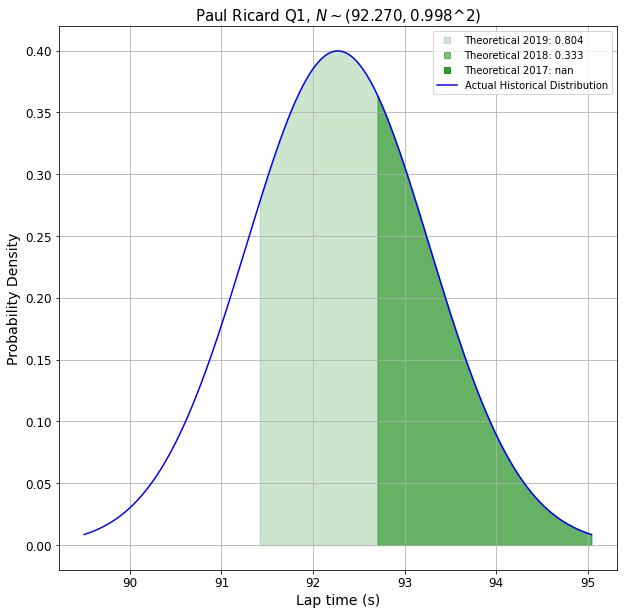

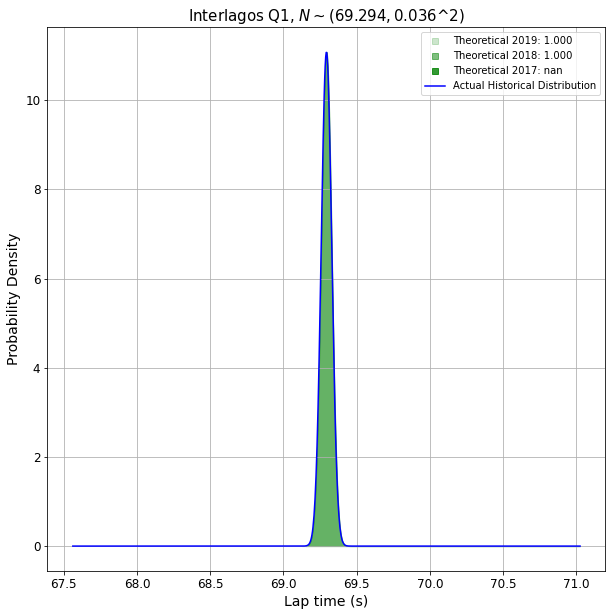

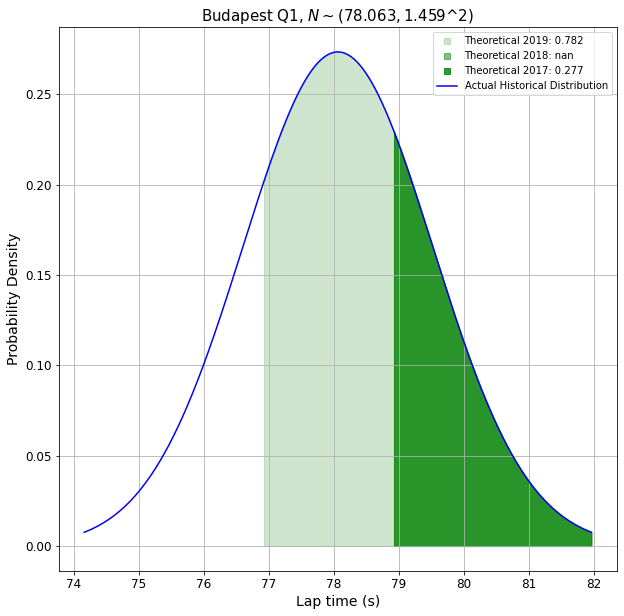

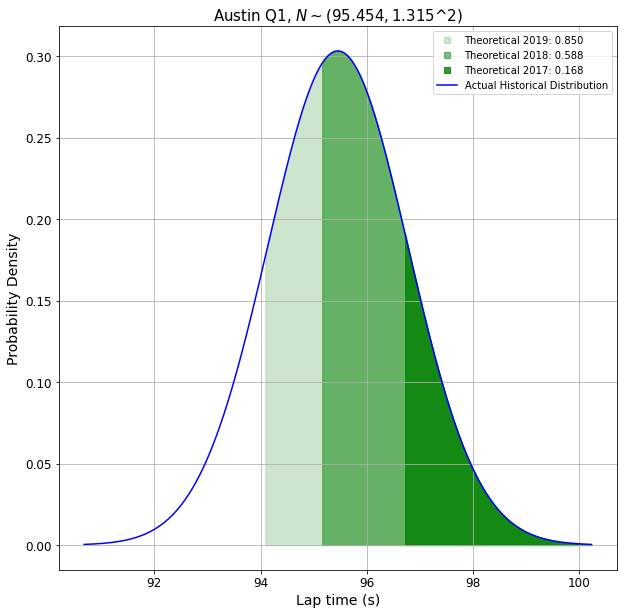

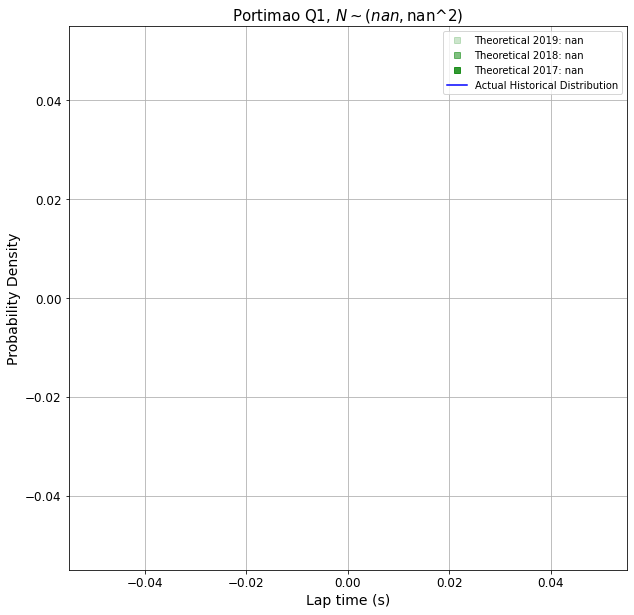

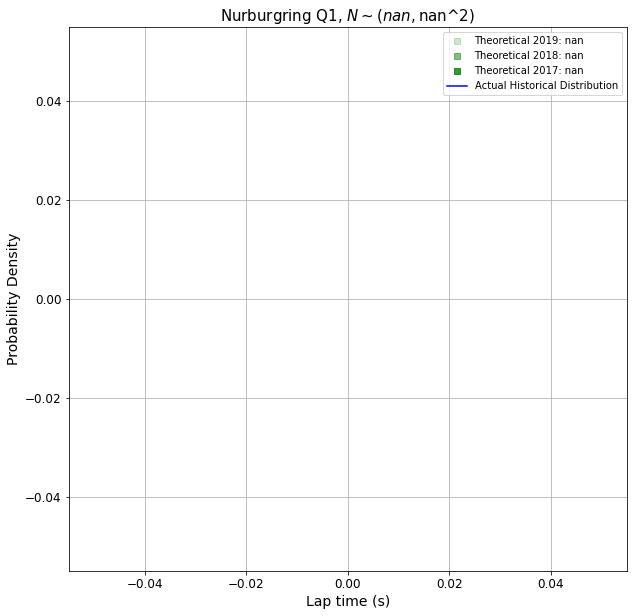

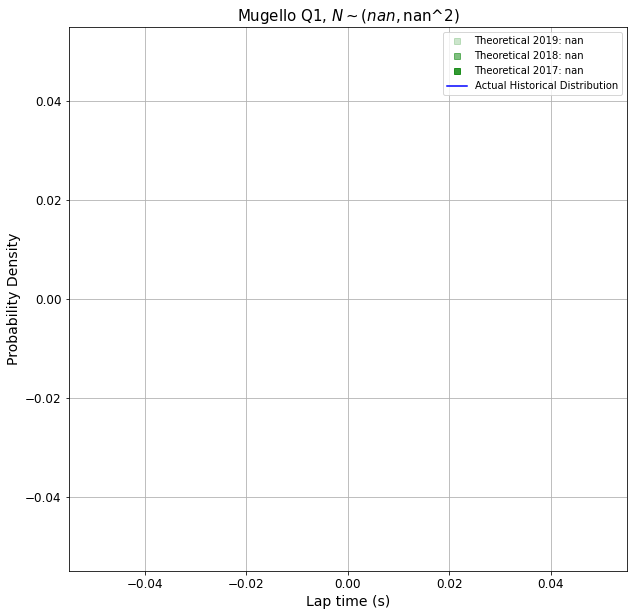

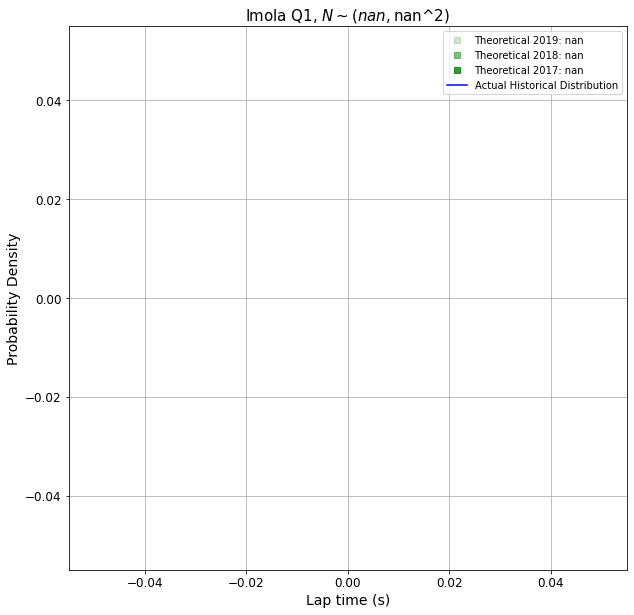

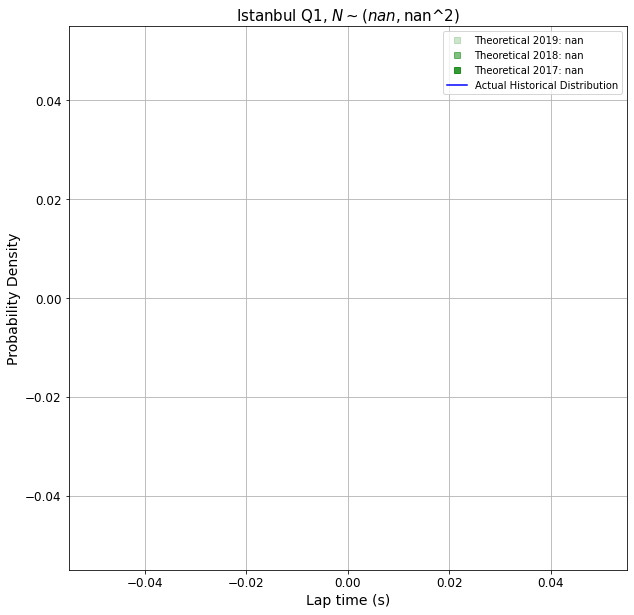

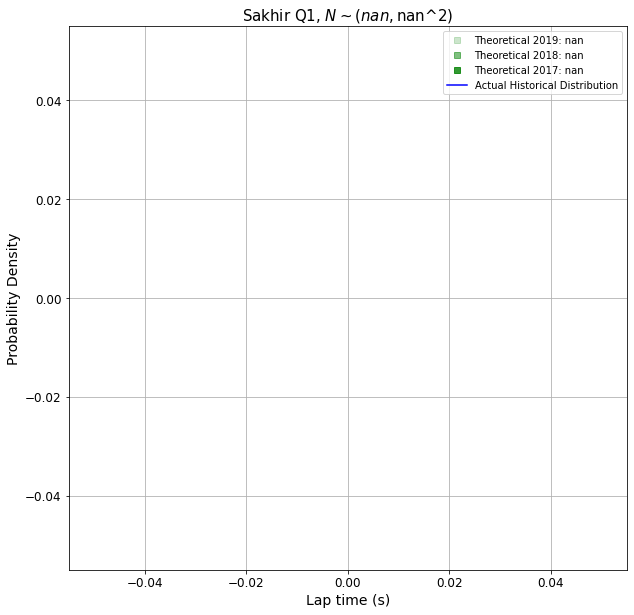

In [108]:
for index in Q1_data.keys():
    norm_curves(index, 'Q1', Q1_df.loc[index, 'Actual Mean'],  Q1_df.loc[index, 'Actual Sd'], Q1_df.loc[index, 'Theoretical 2017'], 
            Q1_df.loc[index, 'Theoretical 2018'], Q1_df.loc[index, 'Theoretical 2019'],
            Q1_df.loc[index, 'Theoretical SF_17'], Q1_df.loc[index, 'Theoretical SF_18'], Q1_df.loc[index, 'Theoretical SF_19'])
    

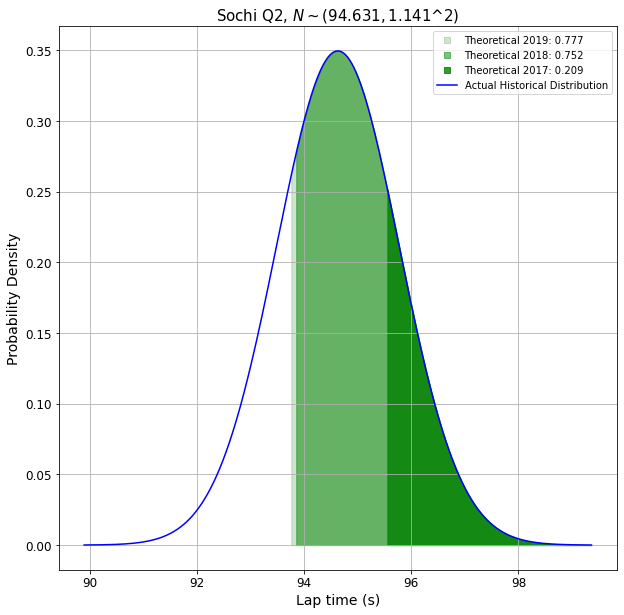

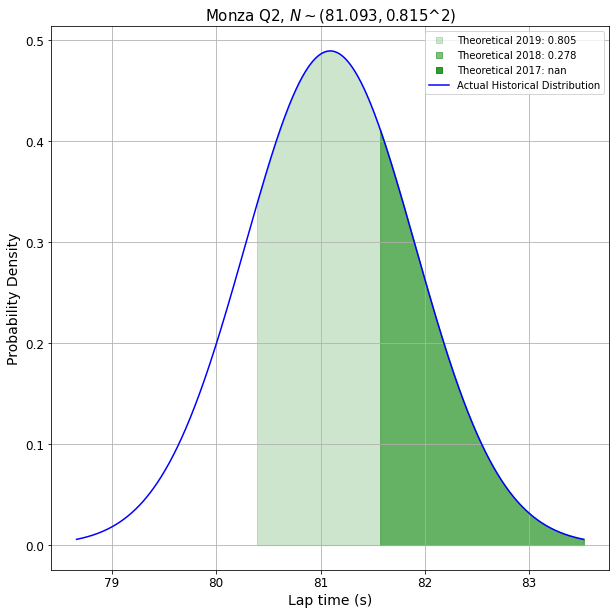

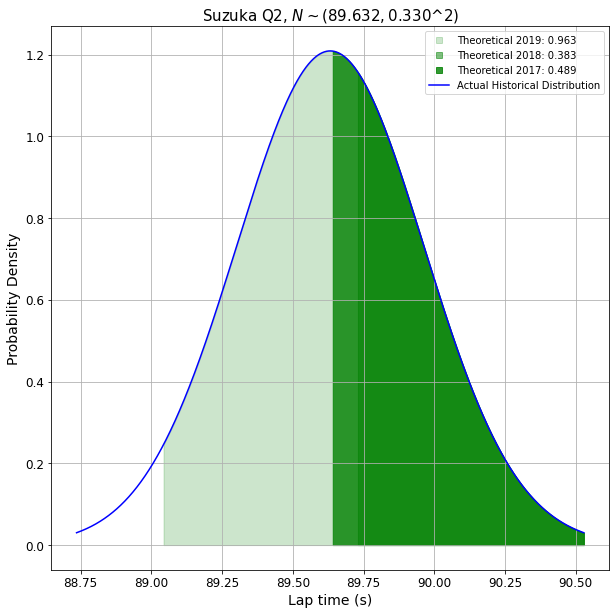

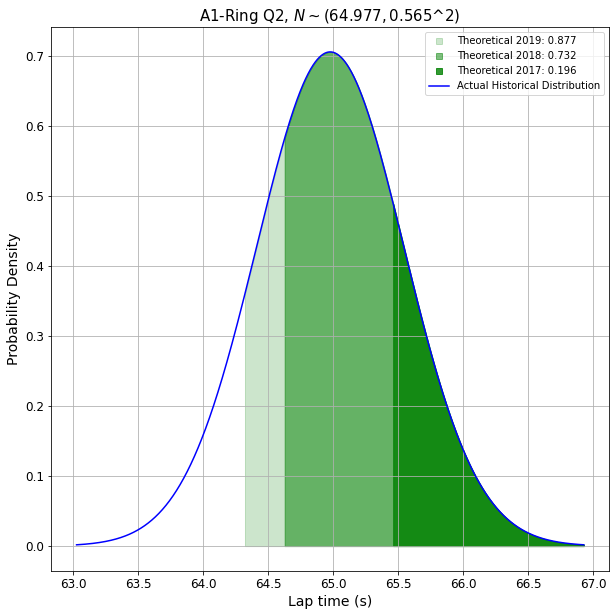

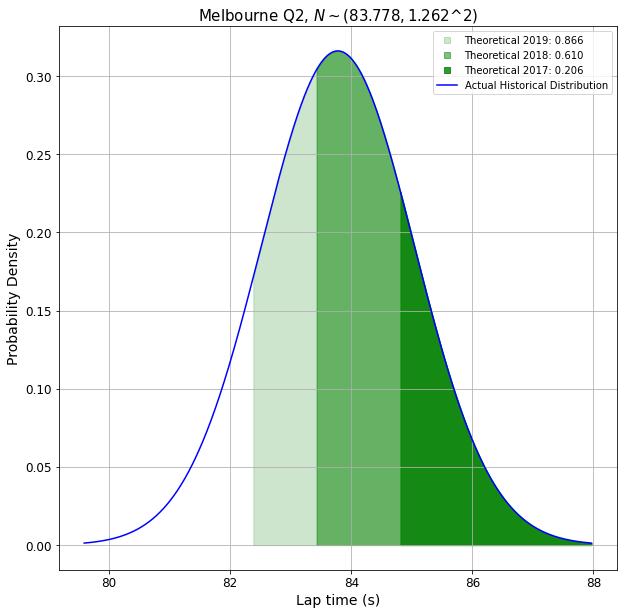

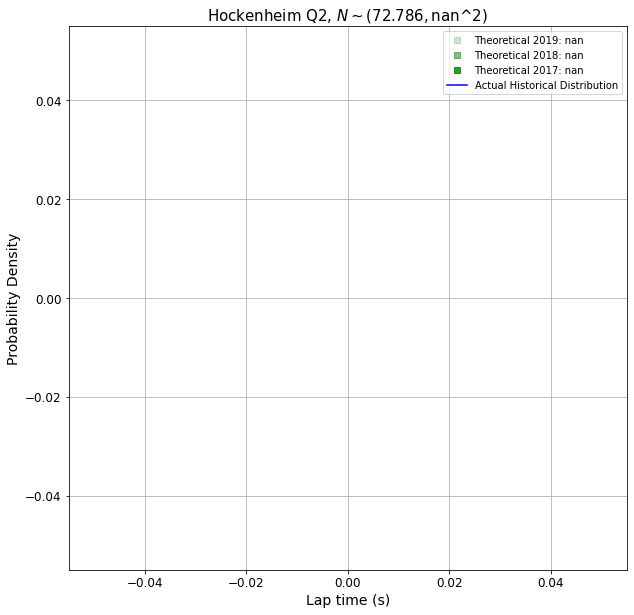

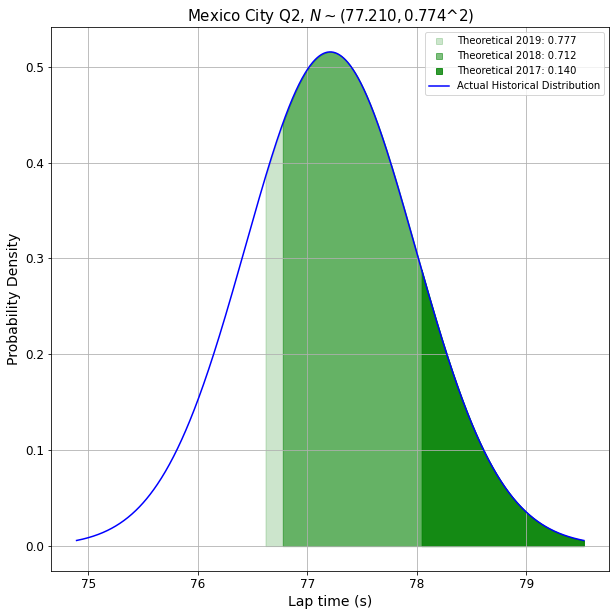

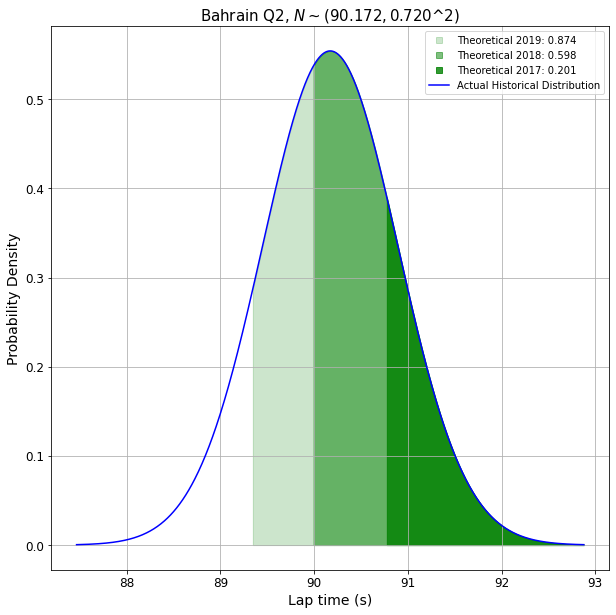

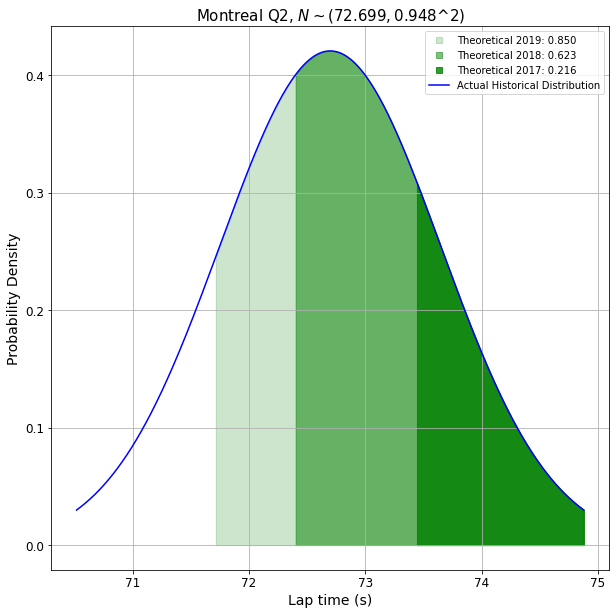

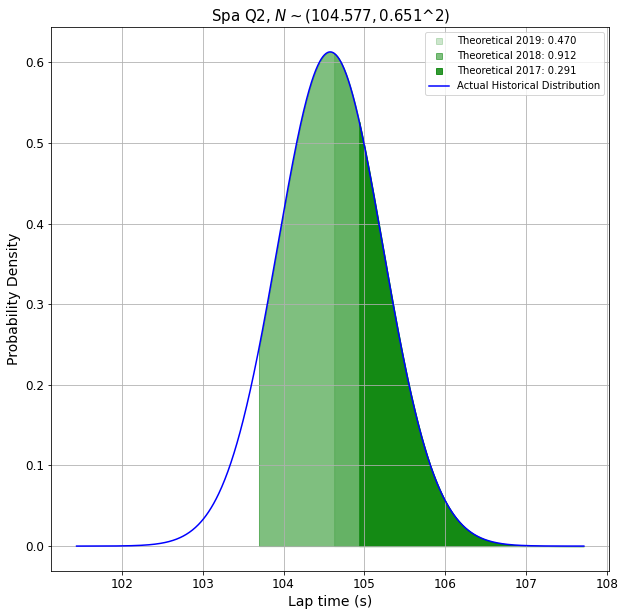

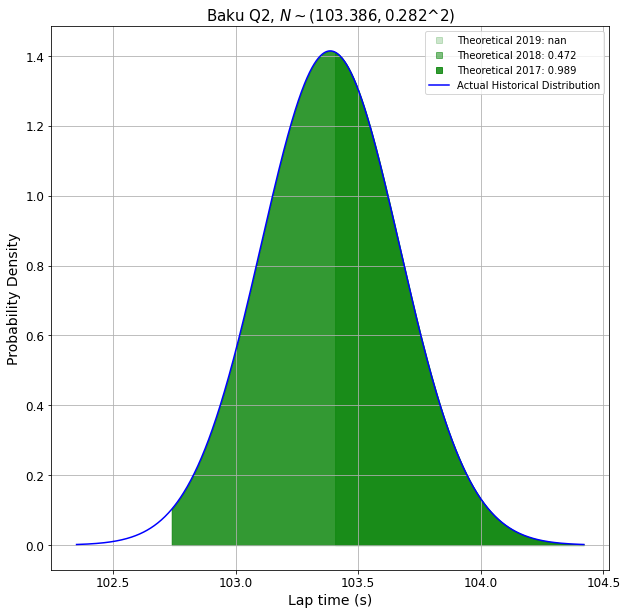

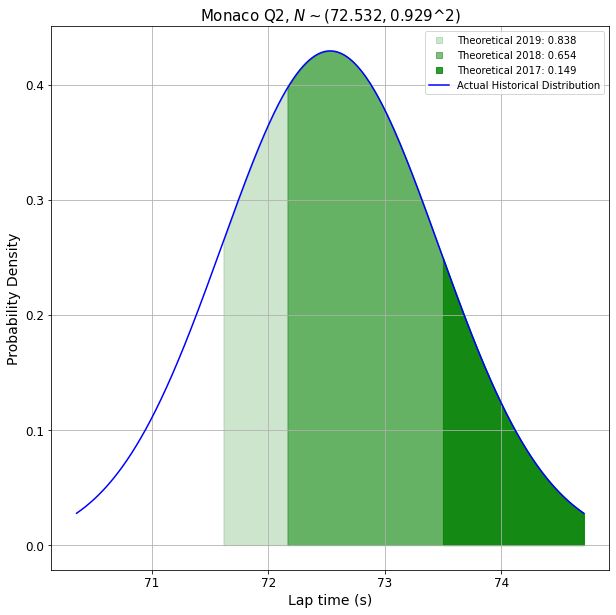

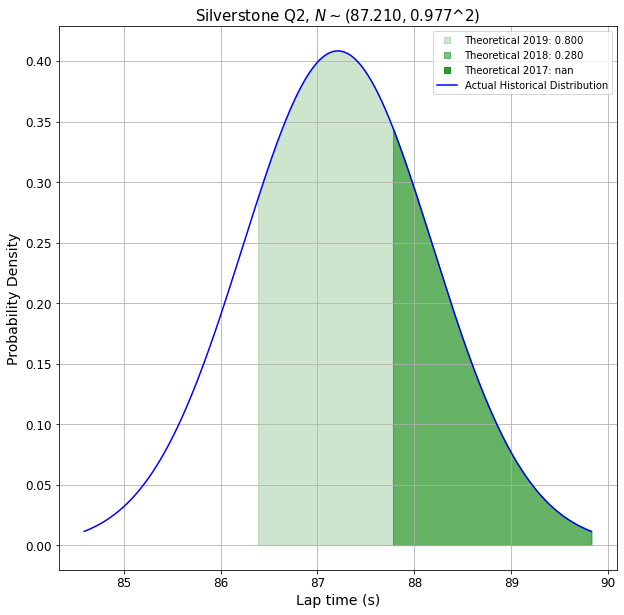

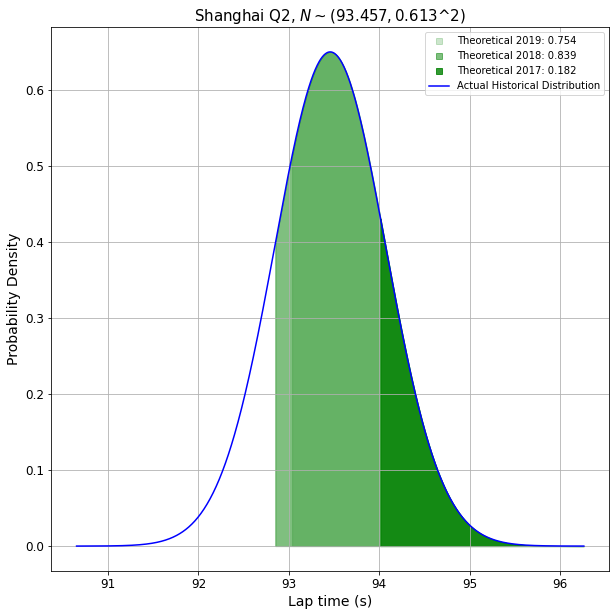

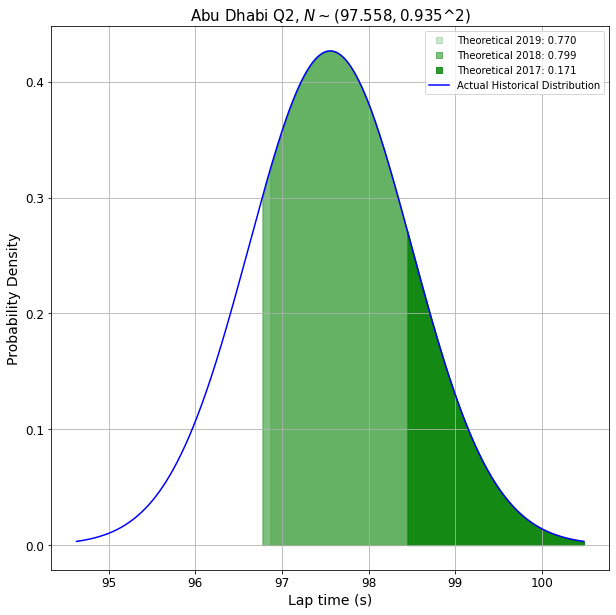

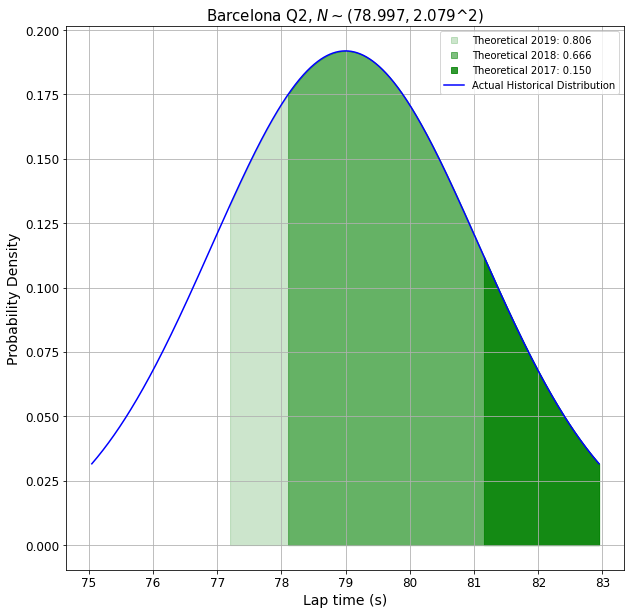

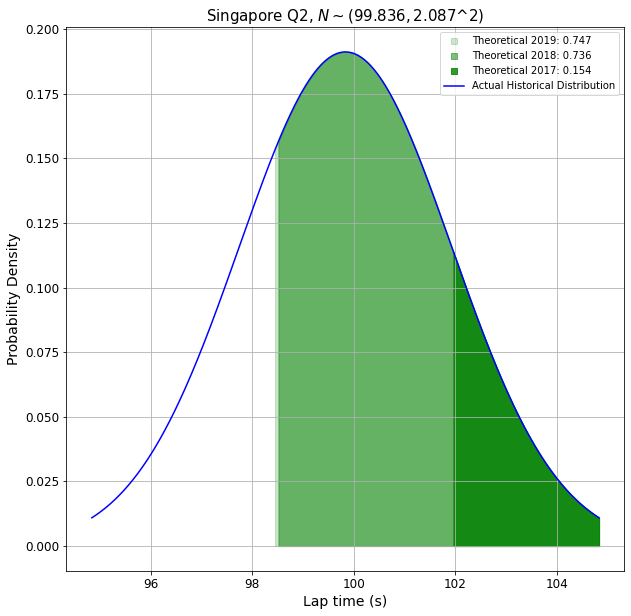

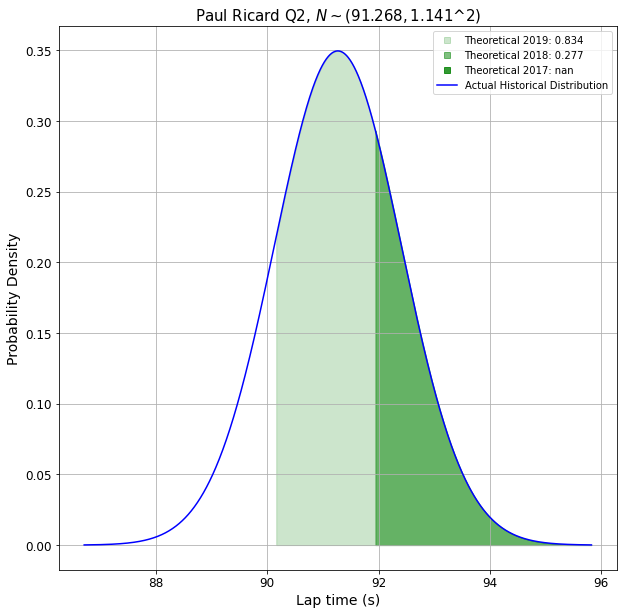

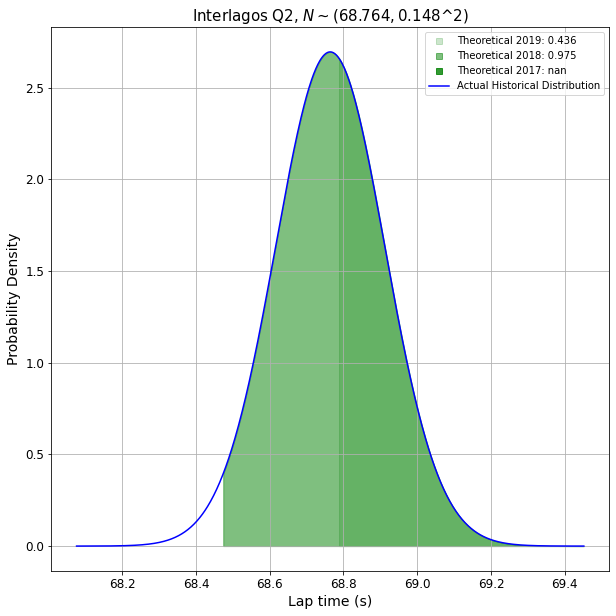

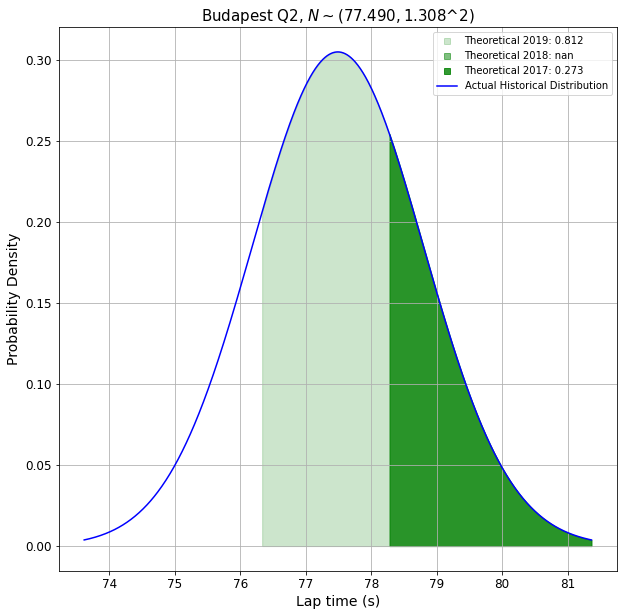

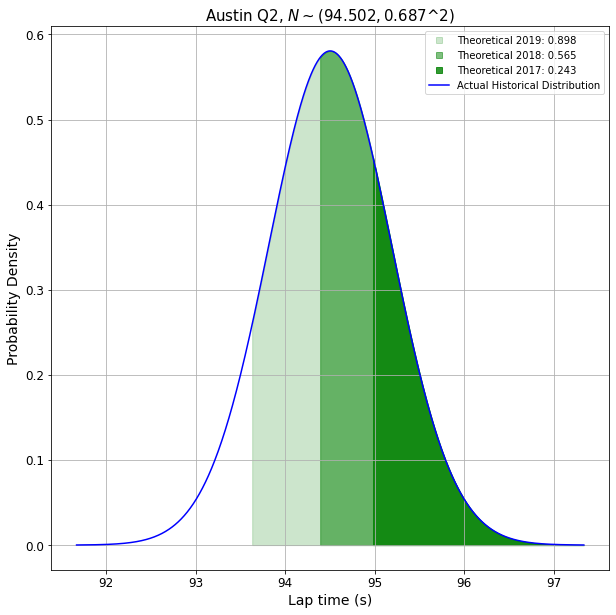

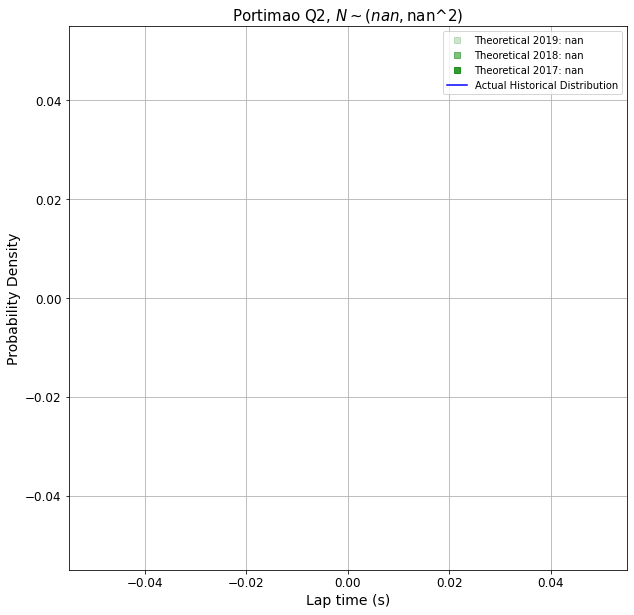

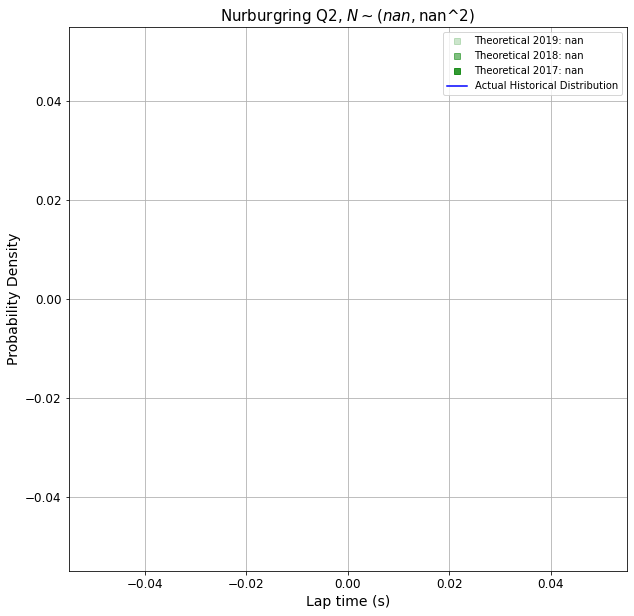

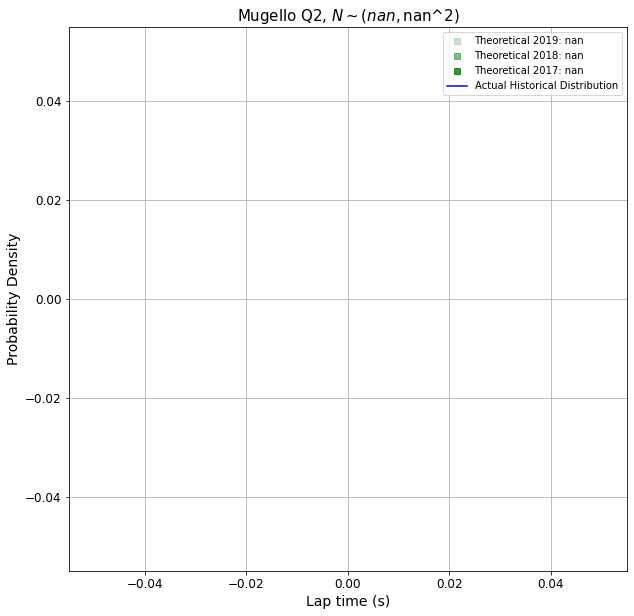

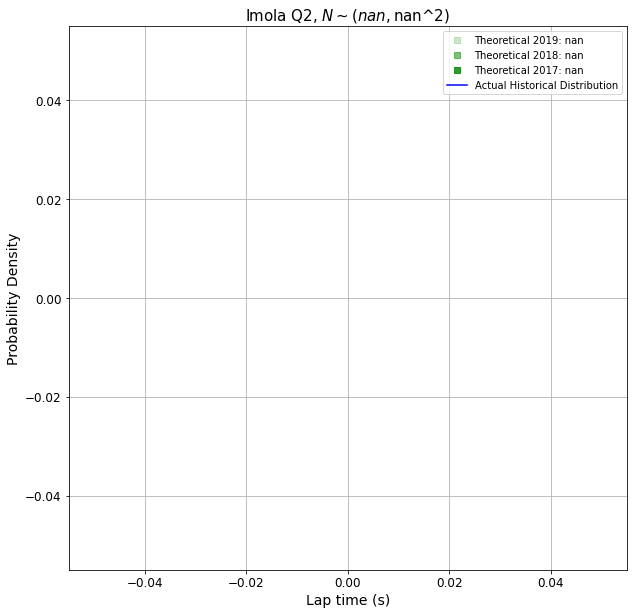

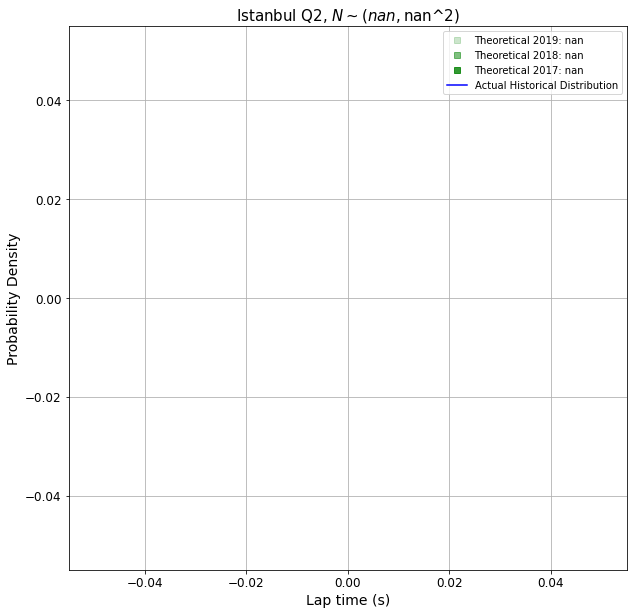

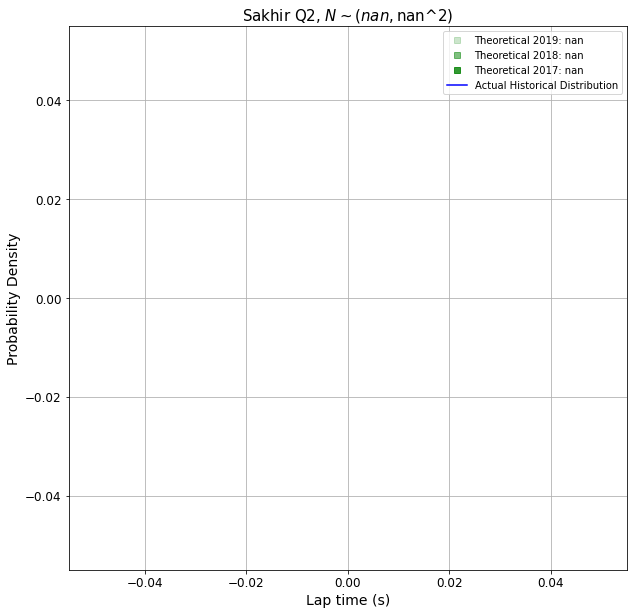

In [109]:
for index in Q2_data.keys():
    norm_curves(index, 'Q2', Q2_df.loc[index, 'Actual Mean'],  Q2_df.loc[index, 'Actual Sd'], Q2_df.loc[index, 'Theoretical 2017'], 
            Q2_df.loc[index, 'Theoretical 2018'], Q2_df.loc[index, 'Theoretical 2019'],
            Q2_df.loc[index, 'Theoretical SF_17'], Q2_df.loc[index, 'Theoretical SF_18'], Q2_df.loc[index, 'Theoretical SF_19'])
    